In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import matplotlib
#matplotlib.use('TkAgg')


In [2]:
# 数据
transform = transforms.Compose([
    transforms.ToTensor(),
])

data_dir = r"D:\cc\Desktop\data"
train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.35MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 114kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 620kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]


In [3]:
# 定义VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 模型参数
input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20

model = VAE(input_dim, hidden_dim, latent_dim)

In [4]:
#模型
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (data, _) in enumerate(train_loader):
        data = data.to(torch.device("cpu"))
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}')

Epoch [1/10], Loss: 222.9277
Epoch [2/10], Loss: 156.6305
Epoch [3/10], Loss: 139.8426
Epoch [4/10], Loss: 131.4154
Epoch [5/10], Loss: 125.9907
Epoch [6/10], Loss: 122.3824
Epoch [7/10], Loss: 119.7602
Epoch [8/10], Loss: 117.8818
Epoch [9/10], Loss: 116.3264
Epoch [10/10], Loss: 115.1024


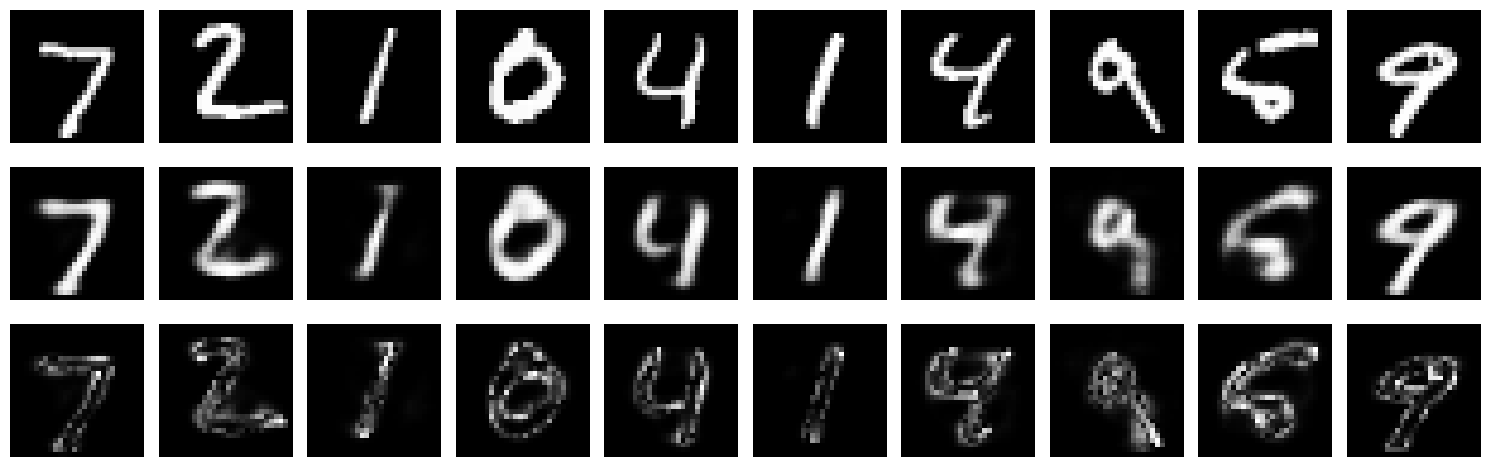

In [5]:
# 可视化
model.eval()
with torch.no_grad():
    test_data_iter = iter(test_loader)
    data, _ = next(test_data_iter)
    data = data[:10].to(torch.device("cpu"))

    recon_batch, _, _ = model(data)
    recon_batch = recon_batch.view(10, 1, 28, 28)

    fig, axes = plt.subplots(3, 10, figsize=(15, 5))

    for i in range(10):
        axes[0, i].imshow(data[i][0], cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(recon_batch[i][0], cmap='gray')
        axes[1, i].axis('off')

        diff = torch.abs(data[i] - recon_batch[i])
        axes[2, i].imshow(diff[0], cmap='gray')
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel('Original', fontsize=12)
    axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
    axes[2, 0].set_ylabel('Difference', fontsize=12)

    plt.tight_layout()
    plt.show()